# Dimensionality Reduction

The goal of this notebook is to study the intrinsic dimensionality of the $G(\tau)$ data present in the dataset.

## Finding the transformation

In [2]:
import numpy as np
import pandas as pd


In [54]:
dataset = pd.read_csv("../G_training.csv",header=None)

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(dataset)
print(pca.explained_variance_ratio_)  


[9.62976156e-01 3.41564575e-02 2.34212057e-03 4.07965761e-04
 1.07999745e-04 8.72116651e-06 5.48938274e-07 2.90910623e-08
 1.36753226e-09 5.71289962e-11]


In [5]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.96297616 0.99713261 0.99947473 0.9998827  0.9999907  0.99999942
 0.99999997 1.         1.         1.        ]


It seems that the data can almost perfectly be compressed using 8 dimensions, istead of the 512. This could represent a huge gain for the training of neural networks. 

## Applying the transformation to Quantum Monte Carlo Data

The problem is that our QMC data do not contain the same number of sampling points. Indeed, for reason of correlation or computation time, some time steps are closer than other... 

In this section, we will try to generate the missing points by putting a smooth line between the data. 

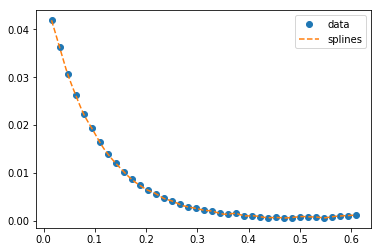

In [33]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
#Import data
qmc_data_G = np.squeeze(pd.read_csv("../../MaxEnt/simulation_harm_osc.csv",usecols=[1]).as_matrix())
qmc_data_tau = np.squeeze(pd.read_csv("../../MaxEnt/simulation_harm_osc.csv",usecols=[0]).as_matrix())
# Interpolate the data
f = interp1d(qmc_data_tau, qmc_data_G, kind='cubic')
tau = np.linspace(qmc_data_tau[0], qmc_data_tau[-1], num=1024, endpoint=True)

# Plot data
plt.plot(qmc_data_tau,qmc_data_G, 'o',tau,f(tau),'--')
plt.legend(['data','splines'],loc='best')
plt.show()




 We can now transform the $f(\tau)$ using PCA transform !

In [38]:
reduced_G=pca.transform(f(tau).reshape(1,1024))
new_G = pca.inverse_transform(reduced_G[:][0:8])

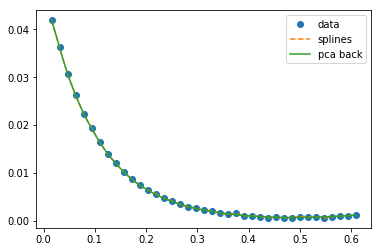

In [42]:
plt.plot(qmc_data_tau,qmc_data_G, 'o',tau,f(tau),'--',tau,new_G[0][:],'-')
plt.legend(['data','splines','pca back'],loc='best')
plt.show()



The transformation, keeping only the 8th first data, seems to keep the main features of $G(\tau)$

## Transforming the dataset

We can proceed to the transformation of the whole dataset :D

In [55]:
pca_def = PCA(n_components=8)
pca_def.fit_transform(dataset)




array([[-3.40471909e+00, -5.70420733e-01, -2.20134854e-01, ...,
        -4.58550551e-03, -7.45927798e-05,  1.84727236e-04],
       [-2.11370044e+00, -9.26820989e-01, -1.93371360e-01, ...,
         1.03428229e-04, -1.10011696e-03,  5.14609000e-04],
       [ 2.40093807e+00,  2.64589276e-01,  6.66036945e-02, ...,
        -6.08971067e-03,  2.61984197e-04, -4.33104831e-07],
       ...,
       [-3.48879523e+00, -3.14667776e-01, -8.56494223e-04, ...,
         1.91779415e-02, -4.22467852e-03,  1.37446643e-04],
       [ 3.53100535e+00,  7.11537057e-01, -7.77627293e-02, ...,
         2.99939288e-03, -1.41099909e-04, -3.47977015e-05],
       [-4.69202086e+00,  1.12690716e+00,  4.58417379e-01, ...,
        -2.63180240e-02,  5.07929038e-04,  1.19472470e-03]])

In [56]:
dataset.to_csv("/Users/romain/Documents/EPFL/C3MP/ACANN_Bis/Data/G_training_reduced.csv",index=False,header=False)



In [59]:
validation_set = pd.read_csv("../G_validation.csv",header=None)
validation_set = pca_def.transform(validation_set)
pd.DataFrame(validation_set).to_csv("/Users/romain/Documents/EPFL/C3MP/ACANN_Bis/Data/G_validation_reduced.csv",index=False,header=False)

ValueError: operands could not be broadcast together with shapes (11100,8) (1024,) 